In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from pathlib import Path
from numpy.random import RandomState

_PRNG = RandomState(0)

In [2]:
_DATA_DIR = "./data"

names = []
dataset = []

for file_name in os.listdir(_DATA_DIR):
    if file_name.endswith(".csv"):
        full_file_path = _DATA_DIR + "/" + file_name
        print(full_file_path)
        dataset.append(pd.read_csv(full_file_path))
        names.append(file_name[10:16])

./data/LoanStats_2016Q1.csv


C:\Users\juszhan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


./data/LoanStats_2016Q2.csv
./data/LoanStats_2016Q3.csv


C:\Users\juszhan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


./data/LoanStats_2016Q4.csv
./data/LoanStats_2017Q1.csv


C:\Users\juszhan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (112) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


./data/LoanStats_2017Q2.csv
./data/LoanStats_2017Q3.csv
./data/LoanStats_2017Q4.csv
./data/LoanStats_2018Q1.csv


C:\Users\juszhan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


./data/LoanStats_2018Q2.csv
./data/LoanStats_2018Q3.csv
./data/LoanStats_2018Q4.csv


In [3]:
verification_status = {k:[] for k in dataset[0]["verification_status"].unique()}

for df in dataset:
    for k,v in df["verification_status"].value_counts().iteritems():
        verification_status[k].append(v)

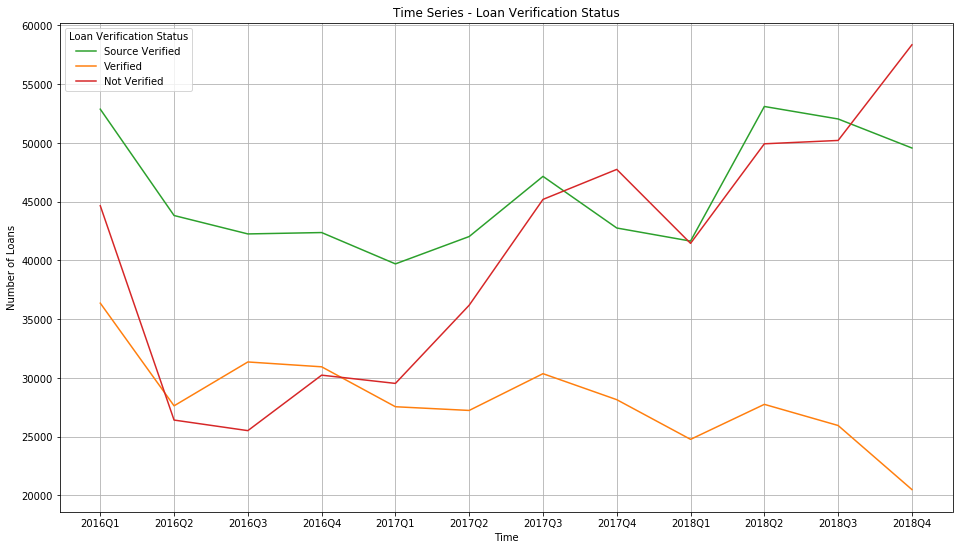

In [4]:
plt.figure(figsize=(16,9))

colors = {
    "Source Verified" : "#2ca02c",
    "Verified" : "#ff7f0e",
    "Not Verified" : "#d62728",
    "Total Loans" : "#1f77b4"
}

x = list(range(len(dataset)))
for k, y in verification_status.items():
    plt.plot(x, y, label=k, color=colors[k])
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Verification Status")
plt.title("Time Series - Loan Verification Status")
plt.show()

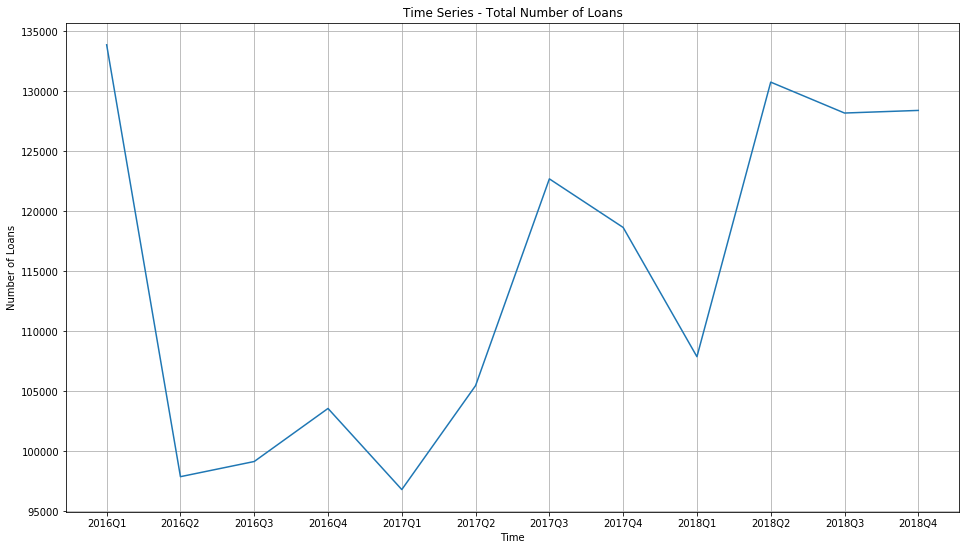

In [5]:
plt.figure(figsize=(16,9))

colors = {
    "Source Verified" : "#2ca02c",
    "Verified" : "#ff7f0e",
    "Not Verified" : "#d62728",
    "Total Loans" : "#1f77b4"
}

x = list(range(len(dataset)))
plt.plot(x, [len(df) for df in dataset], color=colors["Total Loans"])
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.title("Time Series - Total Number of Loans")
plt.show()

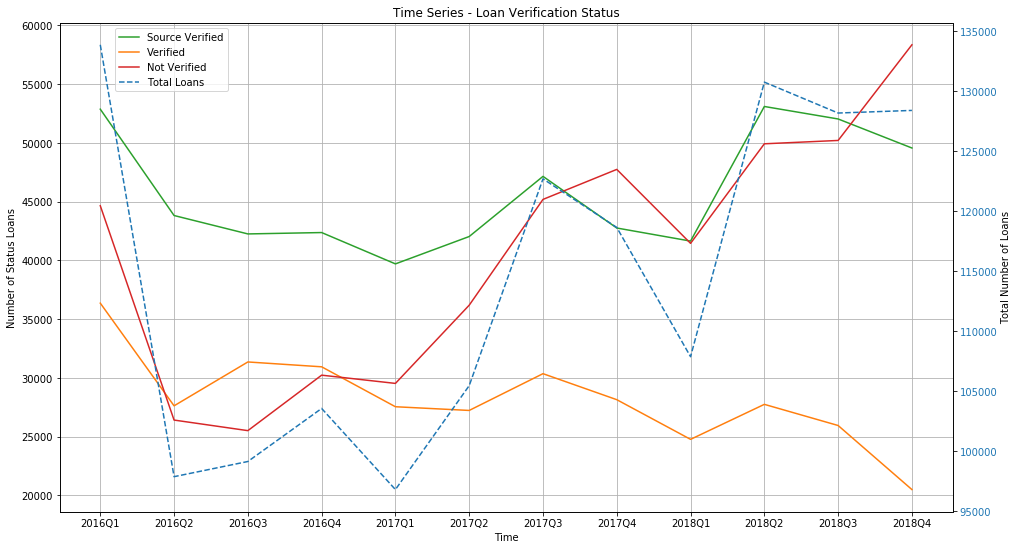

In [6]:
x = list(range(len(dataset)))

fig, ax = plt.subplots(figsize=(16,9))

lns = None

colors = {
    "Source Verified" : "#2ca02c",
    "Verified" : "#ff7f0e",
    "Not Verified" : "#d62728",
    "Total Loans" : "#1f77b4"
}
for k, y in verification_status.items():
    if lns is None:
        lns = ax.plot(x, y, label=k, color=colors[k])
        continue
    lns += ax.plot(x, y, label=k, color=colors[k])
    
ax_right = ax.twinx()
lns += ax_right.plot(x, [len(df) for df in dataset], label="Total Loans", color=colors["Total Loans"], linestyle="--")

plt.xticks(ticks=list(range(len(names))), labels=names)
ax.grid(True)
ax.set_xlabel("Time")
ax.set_ylabel("Number of Status Loans")
# ax.legend(lns, [l.get_label() for l in lns], loc=(.062, .889))
ax.legend(lns, [l.get_label() for l in lns], loc=(.062, .86))

ax_right.set_ylabel("Total Number of Loans")
ax_right.tick_params(axis='y', labelcolor=colors["Total Loans"])
# ax_right.legend(loc=(.83, .95))

plt.title("Time Series - Loan Verification Status")
plt.show()

In [7]:
loan_by_grade = {grade:[] for grade in list("ABCDEFG")}

for df in dataset:
    for k,v in df["grade"].value_counts().iteritems():
        loan_by_grade[k].append(v)
loan_by_grade

{'A': [26482,
  20418,
  11036,
  12911,
  14976,
  17898,
  20796,
  25126,
  26769,
  33016,
  37381,
  38011],
 'B': [40267,
  29550,
  32356,
  32339,
  28776,
  31301,
  36218,
  36832,
  32482,
  38246,
  34776,
  35861],
 'C': [36777,
  27411,
  32846,
  35144,
  33699,
  36880,
  42146,
  32419,
  28747,
  35512,
  31573,
  31018],
 'D': [16454,
  12247,
  14635,
  15842,
  12029,
  12015,
  14736,
  17866,
  15377,
  18544,
  18053,
  17072],
 'E': [9540, 5521, 5450, 5296, 5056, 4847, 5544, 4720, 3691, 4349, 4956, 5962],
 'F': [3482, 2075, 2234, 1543, 1735, 1725, 1568, 1214, 682, 923, 1183, 387],
 'G': [885, 632, 563, 471, 508, 785, 1693, 471, 116, 182, 272, 101]}

In [8]:
sorted_grade = np.argsort(list(loan_by_grade.keys()))

grade = np.array(list(loan_by_grade.keys()))
grade_count = np.array(list(loan_by_grade.values()))

grade_count[sorted_grade]

array([[26482, 20418, 11036, 12911, 14976, 17898, 20796, 25126, 26769,
        33016, 37381, 38011],
       [40267, 29550, 32356, 32339, 28776, 31301, 36218, 36832, 32482,
        38246, 34776, 35861],
       [36777, 27411, 32846, 35144, 33699, 36880, 42146, 32419, 28747,
        35512, 31573, 31018],
       [16454, 12247, 14635, 15842, 12029, 12015, 14736, 17866, 15377,
        18544, 18053, 17072],
       [ 9540,  5521,  5450,  5296,  5056,  4847,  5544,  4720,  3691,
         4349,  4956,  5962],
       [ 3482,  2075,  2234,  1543,  1735,  1725,  1568,  1214,   682,
          923,  1183,   387],
       [  885,   632,   563,   471,   508,   785,  1693,   471,   116,
          182,   272,   101]])

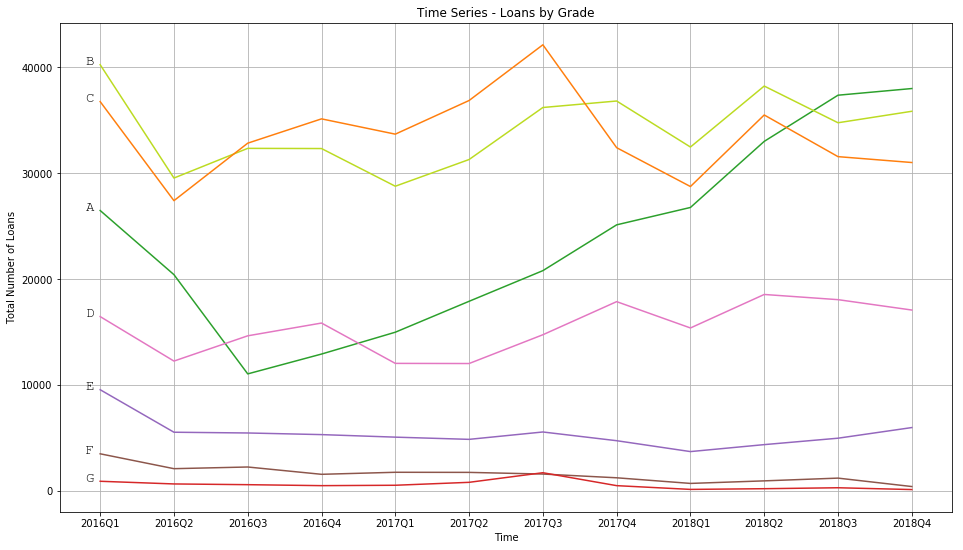

In [9]:
plt.figure(figsize=(16,9))

x = list(range(len(dataset)))
colors = ["#2ca02c", "#bcdb22", "#ff7f0e", "#e377c2", "#9467bd", "#8c564b", "#d62728"]
for y, color, label in zip(grade_count[sorted_grade], colors, list("ABCDEFG")):
    plt.plot(x, y, label=label, color=color)
    plt.annotate(label, xy=(x[0] - 0.2, y[0]), fontname="Courier New", fontsize=14)
plt.xticks(ticks=list(range(len(names))), labels=names)

plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Total Number of Loans")
# plt.legend(loc=2)
plt.title("Time Series - Loans by Grade")
plt.show()

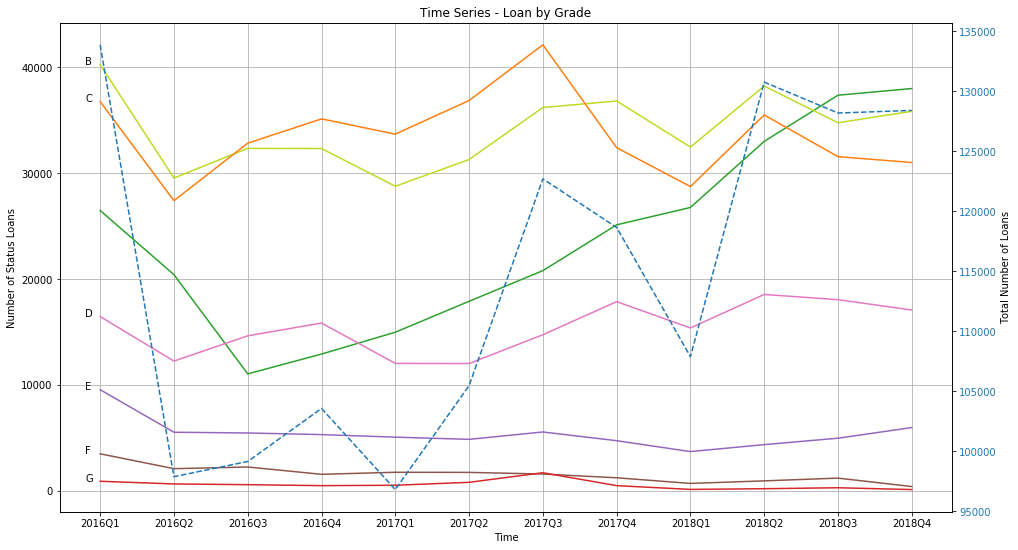

In [10]:
x = list(range(len(dataset)))

fig, ax = plt.subplots(figsize=(16,9))

lns = None

for y, color, label in zip(grade_count[sorted_grade], colors, list("ABCDEFG")):
    if lns is None:
        lns = ax.plot(x, y, label=k, color=color)
        continue
    lns += ax.plot(x, y, label=k, color=color)
    ax.annotate(label, xy=(x[0] - 0.2, y[0]))
    
ax_right = ax.twinx()
lns += ax_right.plot(x, [len(df) for df in dataset], label="Total Loans", color="#1f77b4", linestyle="--")

plt.xticks(ticks=list(range(len(names))), labels=names)
ax.grid(True)
ax.set_xlabel("Time")
ax.set_ylabel("Number of Status Loans")
# ax.legend(lns, [l.get_label() for l in lns], loc=(.062, .86))

ax_right.set_ylabel("Total Number of Loans")
ax_right.tick_params(axis='y', labelcolor="#1f77b4")

plt.title("Time Series - Loan by Grade")
plt.show()

In [21]:
title = {}

idx = 0
for df in dataset:
    for k,v in df["title"].value_counts().iteritems():
        if k not in title:
            title[k] = [0] * idx
        title[k].append(v)
    idx += 1
    for k,v in title.items():
        if len(v) < idx:
            title[k].append(0)
title

{'Debt consolidation': [70437,
  50378,
  53999,
  59749,
  54807,
  58564,
  69259,
  62451,
  55083,
  64141,
  69815,
  70603],
 'Credit card refinancing': [29291,
  18648,
  17716,
  20528,
  21017,
  21254,
  23894,
  25308,
  24577,
  32822,
  35342,
  34961],
 'Home improvement': [8090,
  7422,
  6979,
  7393,
  7058,
  9222,
  9734,
  8678,
  7640,
  9652,
  7944,
  7512],
 'Other': [6830,
  6528,
  7004,
  7383,
  6130,
  7139,
  8939,
  10846,
  9739,
  11309,
  6881,
  7094],
 'Major purchase': [2737,
  2445,
  2379,
  2470,
  2167,
  2617,
  3124,
  3228,
  3217,
  3763,
  2339,
  2303],
 'Medical expenses': [1376,
  1190,
  1174,
  1468,
  1353,
  1648,
  1919,
  1964,
  1765,
  1958,
  1400,
  1499],
 'Business': [1291,
  1045,
  1000,
  1216,
  1146,
  1036,
  1266,
  1493,
  1346,
  1243,
  943,
  1051],
 'Car financing': [1231,
  1050,
  1178,
  1162,
  1121,
  1333,
  1514,
  1393,
  1361,
  1525,
  1056,
  1037],
 'Moving and relocation': [716,
  769,
  864,
  772,
 

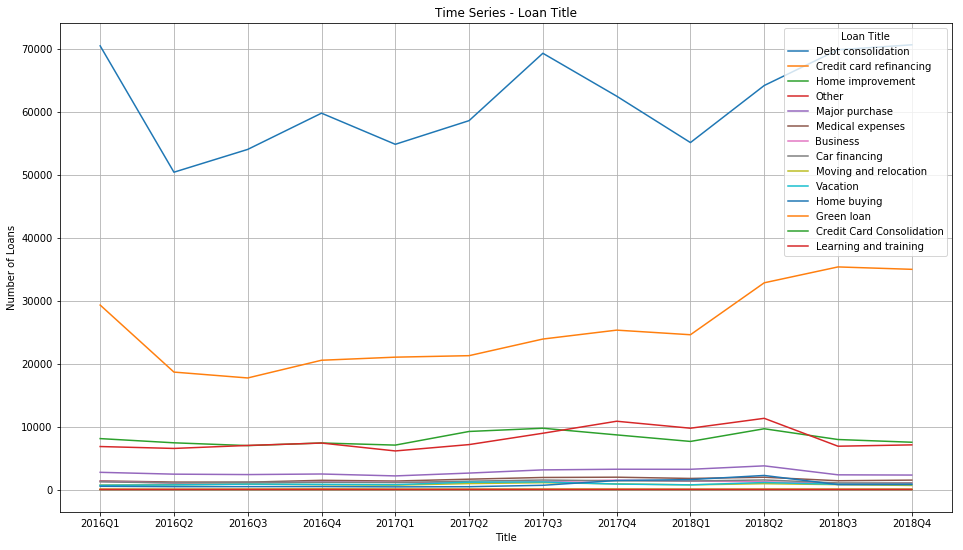

In [23]:
plt.figure(figsize=(16,9))


x = list(range(len(dataset)))
for k, y in title.items():
    plt.plot(x, y, label=k)
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.grid(True)
plt.xlabel("Title")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Title")
plt.title("Time Series - Loan Title")
plt.show()

In [25]:
title = {
    "Debt consolidation": [0] * len(dataset),
    "Credit card refinancing": [0] * len(dataset),
    "Home improvement": [0] * len(dataset),
    "Other": [0] * len(dataset)
    
}

for idx, df in enumerate(dataset):
    for k,v in df["title"].value_counts().iteritems():
        if k not in title:
            title["Other"][idx] += v
            continue
        title[k][idx] += v

title

{'Debt consolidation': [70437,
  50378,
  53999,
  59749,
  54807,
  58564,
  69259,
  62451,
  55083,
  64141,
  69815,
  70603],
 'Credit card refinancing': [29291,
  18648,
  17716,
  20528,
  21017,
  21254,
  23894,
  25308,
  24577,
  32822,
  35342,
  34961],
 'Home improvement': [8090,
  7422,
  6979,
  7393,
  7058,
  9222,
  9734,
  8678,
  7640,
  9652,
  7944,
  7512],
 'Other': [15448,
  14285,
  14999,
  15872,
  13897,
  16411,
  19814,
  22211,
  20564,
  24157,
  15093,
  15336]}

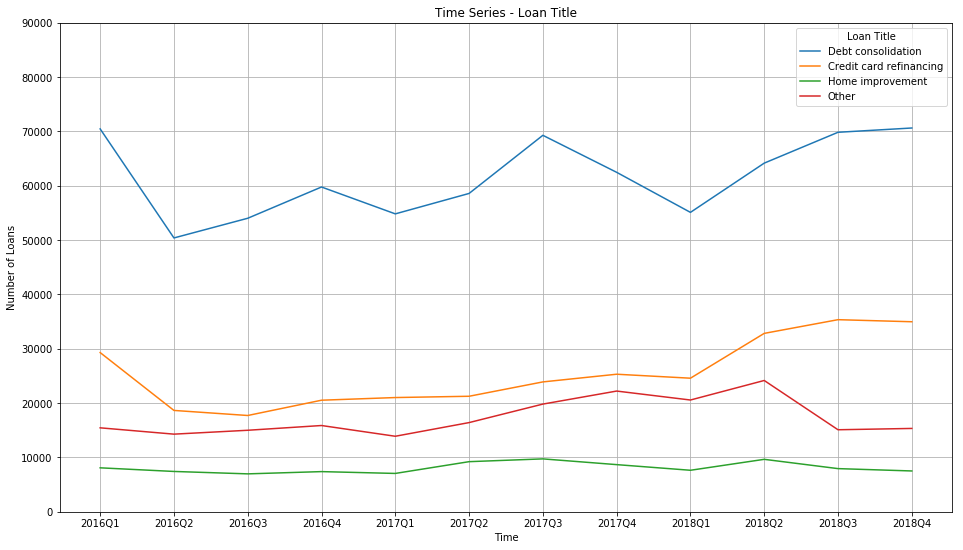

In [26]:
plt.figure(figsize=(16,9))


x = list(range(len(dataset)))
for k, y in title.items():
    plt.plot(x, y, label=k)
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.ylim(bottom=0, top=90000)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Title")
plt.title("Time Series - Loan Title")
plt.show()